# Proyecto Final Batalla de Vecindarios

# Tabla de Contenido

- Descripción del problema
- Antecedentes
- Descripción de los datos



## Descripción del problema

En los últimos años la ciudad de Mérida ha tenido un crecimiento exponencial en el número de habitantes. Los principales factores o motivos por lo que las personas de distintos estados deciden inmigrar a Mérida es por el tema de seguridad y los niveles bajos de violencia; así como el incremento en la inversión privada y extranjera que esta llegando a la ciudad, por lo que la oferta de trabajo es alta en comparación a otras ciudades. Eso ha ocasionado que haya un crecimiento en la demanda de unidades habitacionales.

Por lo que muchas personas buscan el mejor lugar para residir en la ciudad, que cuente con servicios, con parques, escuelas, etc. Cerca de su residencia, por lo que con apoyo de algunos datos extraídos de la web y de la API de Foursquuare realizaremos un análisis de cluster, para poder determinar cuales son los mejores colonias/fraccionamientos para habitar en Mérida si eres una persona de otra región.

## Antecedentes

De acuerdo al censo del 2020 la ciudad de Mérida ocupa el puesto #11 entre las zonas metropolitanas con mayor población. Además, Mérida es una de las pocas ciudades que aceleraron su crecimiento respecto a la década anterior (1.9% anual), lo cual en gran parte se dio como resultado de una alta y atípica migración; pues con 80,000 nuevos residentes, Mérida es la octava ciudad del país que más personas recibió de otros estados durante el último quinquenio.

En 2020, la población en Mérida fue de 995,129 habitantes (48.2% hombres y 51.8% mujeres). En comparación a 2010, la población en Mérida creció un 19.8%.

Los altos índices de seguridad que presenta Mérida motivan a miles de familias de todas partes de la república a mudarse a esta ciudad cada año. Esto ha contribuido al acelerado crecimiento del sector inmobiliario, al construirse decenas de desarrollos y privadas residenciales dentro y fuera de la ciudad, con la intención de albergar a todas estas familias.

De ser una entidad federativa expulsora de población, hace 30 años, ahora es receptora, lo que refleja el interés de otras partes del país y del extranjero por las ventajas que ofrece en empleos, certeza y seguridad jurídica de las inversiones, grado de escolaridad y menor percepción de inseguridad, entre otros.

## Librerías a emplear

In [132]:
import numpy as np # librería para manejar datos vectorizados

import pandas as pd # librería para análisis de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # librería para manejar archivos JSON 

#!conda install -c conda-forge geopy --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare 
from geopy.geocoders import Nominatim # convertir una dirección en valores de latitud y longitud

import requests # librería para manejar solicitudes
from pandas.io.json import json_normalize # librería para convertir un archivo json en un dataframe pandas

# Matplotlib y módulos asociados para graficar
import matplotlib.cm as cm
import matplotlib.colors as colors

# importar k-means desde la fase de agrupación
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare
import folium # librería para graficar mapas 

import matplotlib.pyplot as plt #librería para graficar
%matplotlib inline 

print('Libraries imported.')

Libraries imported.


## Descripción de los datos

Los datos que vamos a emplear para el respectivo análisis de este problema son los siguientes:



- https://raw.githubusercontent.com/FernandoCastro29/Coursera_Capstone/main/ZipCod_lat_lon_Neigh_Merida.csv

Dicha archivo, trae la información del código postal de las colonias que hay en Mérida, así como también las coordenadas de su latitud y longitud, que nos será de extrema utilidad cuando empleemos la API de Foursquare para revisar la información de los tipos de servicios que hay en un radio de 500 metros por cada colonia/Fraccionamiento.

Leemos el archivo csv

In [12]:
file_name ='https://raw.githubusercontent.com/FernandoCastro29/Coursera_Capstone/main/ZipCod_lat_lon_Neigh_Merida.csv'
Merida = pd.read_csv(file_name)
Merida.columns = ['CP','Colonia','Latitud','Longitud']

Procedemos a echarle un vistazo a los primeros datos que se encuentra en ella

In [13]:
Merida.head()

CP                        Colonia    Latitud   Longitud
0  97000      jardines de san sebastian  20.989200 -89.756400
1  97000            privada del maestro  20.982308 -89.626156
2  97000                  merida centro  20.968927 -89.645942
3  97000                      los cocos  20.948595 -89.630134
4  97000  privada garcia gineres c - 29  20.989226 -89.638116

Como podemos observar nuestro data.frame esta constituido por 4 columnas, la primera es el código postal por cada colonia, la segunda es el nombre del Fraccionamiento o colonia, la tercera y la cuarta son los datos geoespaciales que vamos a emplear para la API Foursquare como son la Latitud y Longitud.

### Barrios Unicos en Mérida

In [14]:
print('Existen {} unicos Bariios en Mérida.'.format(len(Merida['Colonia'].unique())))

Existen 658 unicos Bariios en Mérida.


### Agrupación y segmentación de los vecindarios

Utilizaremos la libreria geopy para obtener la latitud y longitud de la Ciudad de Mérida

In [15]:
address = 'MERIDA,MEXICO'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Las coordenadas geograficas de Mérida son {}, {}.'.format(latitude, longitude))

Las coordenadas geograficas de Mérida son 20.9670759, -89.6237402.


### Generamos el mapa de Mérida con las colonias superpuestos por encima

In [25]:
mapa_Merida = folium.Map(location=[latitude, longitude], zoom_start=12)

# añadir marcadores al mapa
for lat, lng, neighborhood in zip(Merida['Latitud'], Merida['Longitud'], Merida['Colonia']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='gold',
        fill=True,
        fill_color='skyblue',
        fill_opacity=0.7,
        parse_html=False).add_to(mapa_Merida)  
    
mapa_Merida

### Explorar Barrios en Mérida

Procedemos a crear nuestra función para explorar los barrios con ayuda de la API de Foursquare

In [113]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,limit=10):
    
    URL='https://api.foursquare.com/v3/places/search?ll={},{}&radius={}&limit={}'
    headers = {
        'Accept': 'application/json',
        'Authorization': 'fsq3z8M+K9/afb++fE1PLmG6xOKTPAj/SsruzHI0bYoklOk='
    }
    df_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = URL.format(lat, lng, radius, limit)
        results = requests.get(url,headers = headers).json()
        if not results.get('results'):
            continue
        else:
            j = len(results.get('results'))
            for i in range(0,j):
                result = {}
                result['Neighborhood']=name
                result['Neighborhood Latitude']=lat
                result['Neighborhood Longitude']=lng
                result['Name']=results.get('results')[i]['name']
                result['Venue Latitude']=results.get('results')[i]['geocodes']['main']['latitude']
                result['Venue Longitude']=results.get('results')[i]['geocodes']['main']['longitude']
                if len(results.get('results')[i]['categories'])!= 0:
                    result['Category_Names']=results.get('results')[i]['categories'][0]['name']
                else:
                    result['Category_Names']= 0
                df_list.append(result.copy())    
    return pd.DataFrame(df_list)

Ahora ejecutamos la función anterior para cada colonia y creamos un nuevo dataframe llamado Merida_Venues

In [114]:
Merida_venues = getNearbyVenues(names=Merida['Colonia'],
                                   latitudes=Merida['Latitud'],
                                   longitudes=Merida['Longitud'])

In [116]:
Merida_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  privada del maestro              20.982308              -89.626156   
1  privada del maestro              20.982308              -89.626156   
2  privada del maestro              20.982308              -89.626156   
3  privada del maestro              20.982308              -89.626156   
4  privada del maestro              20.982308              -89.626156   

                       Name  Venue Latitude  Venue Longitude  \
0                   Chinita       20.982386       -89.626134   
1                      Oxxo       20.982472       -89.625679   
2                Big Chiken       20.982241       -89.625826   
3  Taller Electrico Pacheco       20.981948       -89.626308   
4                 La Gloria       20.981885       -89.626289   

                Category_Names  
0           Chinese Restaurant  
1  Grocery Store / Supermarket  
2                  Wings Joint  
3            Automotive Retail  
4              Taco Restaurant

Eliminamos los elementos que le asignamos 0 en la columna 'Category_Names'

In [117]:
Merida_venues.drop(Merida_venues[Merida_venues['Category_Names'] == 0].index, inplace=True)

#### Revisemos el tamaño del dataframe resultante

In [118]:
print(Merida_venues.shape)
Merida_venues.head()

(3060, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  privada del maestro              20.982308              -89.626156   
1  privada del maestro              20.982308              -89.626156   
2  privada del maestro              20.982308              -89.626156   
3  privada del maestro              20.982308              -89.626156   
4  privada del maestro              20.982308              -89.626156   

                       Name  Venue Latitude  Venue Longitude  \
0                   Chinita       20.982386       -89.626134   
1                      Oxxo       20.982472       -89.625679   
2                Big Chiken       20.982241       -89.625826   
3  Taller Electrico Pacheco       20.981948       -89.626308   
4                 La Gloria       20.981885       -89.626289   

                Category_Names  
0           Chinese Restaurant  
1  Grocery Store / Supermarket  
2                  Wings Joint  
3            Automotive Retail  
4              Taco Restaurant

### Revisemos cuantos sitios se registraron para cada barrio

In [119]:
Merida_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                      
60 norte                                                      9   
aguilas chuburna                                              3   
alcal martin                                                 10   
algarrobos desarrollo residencial                             4   
almendros                                                    10   
altabrisa                                                    10   
altavista                                                     1   
alvaro torres                                                 1   
amalia solorzano                                              8   
amapola                                                      10   
ampliaciun francisco de montejo                              10   
ampliaciun lindavista (elefante chico)                        8   
ampliaciun pedregales de lindavista                           8   
aquaparque                                                    8   
arboledas chuburna                                           10   
arcos del sol                                                 9   
arekas                                                       10   
armando avila gurrutia                                        9   
aurea residencial                                            10   
azcorra                                                       8   
azcorra ii                                                    8   
benito jurez nte                                              8   
benito jurez ote                                              8   
bogdan                                                        7   
bojorquez                                                     9   
bosques de oriente                                            9   
bosques del pedregal                                          1   
brisas de chuburna                                           10   
brisas de san jose                                            2   
brisas del poniente (yucalpeten)                              9   
buenavista                                                   10   
bugambilias                                                   9   
callejones de chuburna                                        7   
camara de comercio norte                                     10   
camara de la construcciun                                    10   
campestre                                                     9   
carrillo ancona                                              10   
castilla camara                                               1   
caucel                                                        8   
central de abasto                                             9   
centro sct yucatn                                            10   
cerillera                                                     9   
chablekal                                                     6   
chenku                                                        8   
cheumn                                                        1   
chichen-itza                                                  6   
cholul                                                       10   
chuburna de hidalgo                                           9   
chuburna de hidalgo iii                                      10   
chuburna de hidalgo iv                                       10   
chuburna de hidalgo v                                        10   
circuito colonias                                             9   
club de golf la ceiba                                         1   
cocoteros                                                    10   
cocoyoles                                                    10   
colonial buenavista                                           3   
colonial chuburna                                             3   
cordeleros de chuburna                                        9   
cordemex              

Encontremos cuantas categorías únicas se pueden conservar de todos los sitios registrados

In [120]:
print('Hay {} categorias unicas.'.format(len(Merida_venues['Category_Names'].unique())))

Hay 285 categorias unicas.


### Analizamos cada barrio

In [121]:
# codificación
Merida_onehot = pd.get_dummies(Merida_venues[['Category_Names']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
Merida_onehot['Neighborhood'] = Merida_venues['Neighborhood'] 

# mover la columna de barrio a la primer columna
fixed_columns = [Merida_onehot.columns[-1]] + list(Merida_onehot.columns[:-1])
Merida_onehot = Merida_onehot[fixed_columns]

Merida_onehot.head()

Neighborhood  ATM  Accounting and Bookkeeping Service  \
0  privada del maestro    0                                   0   
1  privada del maestro    0                                   0   
2  privada del maestro    0                                   0   
3  privada del maestro    0                                   0   
4  privada del maestro    0                                   0   

   Advertising Agency  Afghan Restaurant  American Restaurant  Amusement Park  \
0                   0                  0                    0               0   
1                   0                  0                    0               0   
2                   0                  0                    0               0   
3                   0                  0                    0               0   
4                   0                  0                    0               0   

   Antique Store  Aquarium  Arcade  Argentinian Restaurant  Art Gallery  \
0              0         0       0                       0            0   
1              0         0       0                       0            0   
2              0         0       0                       0            0   
3              0         0       0                       0            0   
4              0         0       0                       0            0   

   Arts and Crafts Store  Arts and Entertainment  Asian Restaurant  \
0                      0                       0                 0   
1                      0                       0                 0   
2                      0                       0                 0   
3                      0                       0                 0   
4                      0                       0                 0   

   Attorney / Law Office  Automotive Repair Shop  Automotive Retail  \
0                      0                       0                  0   
1                      0                       0                  0   
2                      0                       0                  0   
3                      0                       0                  1   
4                      0                       0                  0   

   Automotive Service  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  \
0                   0          0           0           0       0     0   
1                   0          0           0           0       0     0   
2                   0          0           0           0       0     0   
3                   0          0           0           0       0     0   
4                   0          0           0           0       0     0   

   Banking and Finance  Bar  Barbershop  Baseball Field  Basketball Court  \
0                    0    0           0               0                 0   
1                    0    0           0               0                 0   
2                    0    0           0               0                 0   
3                    0    0           0               0                 0   
4                    0    0           0               0                 0   

   Bath House  Beach  Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  \
0           0      0         0            0           0                   0   
1           0      0         0            0           0                   0   
2           0      0         0            0           0                   0   
3           0      0         0            0           0                   0   
4           0      0         0            0           0                   0   

   Big Box Store  Bistro  Board Store  Bookstore  Botanical Garden  Boutique  \
0              0       0            0          0                 0         0   
1              0       0            0          0                 0         0   
2              0       0            0          0                 0         0   
3              0       0            0          0                 0         0   
4              0       0            0 

Examinemos el tamaño del nuevo dataframe

In [122]:
Merida_onehot.shape

(3060, 286)

#### Agrupemos las filas por barrios tomando la média de la frecuancia de la ocurrencia de cada categoría

In [123]:
Merida_grouped = Merida_onehot.groupby('Neighborhood').mean().reset_index()
Merida_grouped

Neighborhood    ATM  \
0                                    60 norte  0.000   
1                            aguilas chuburna  0.000   
2                                alcal martin  0.000   
3           algarrobos desarrollo residencial  0.000   
4                                   almendros  0.000   
5                                   altabrisa  0.000   
6                                   altavista  0.000   
7                               alvaro torres  0.000   
8                            amalia solorzano  0.000   
9                                     amapola  0.000   
10            ampliaciun francisco de montejo  0.000   
11     ampliaciun lindavista (elefante chico)  0.000   
12        ampliaciun pedregales de lindavista  0.000   
13                                 aquaparque  0.000   
14                         arboledas chuburna  0.000   
15                              arcos del sol  0.000   
16                                     arekas  0.000   
17                     armando avila gurrutia  0.000   
18                          aurea residencial  0.000   
19                                    azcorra  0.000   
20                                 azcorra ii  0.000   
21                           benito jurez nte  0.000   
22                           benito jurez ote  0.000   
23                                     bogdan  0.000   
24                                  bojorquez  0.000   
25                         bosques de oriente  0.000   
26                       bosques del pedregal  0.000   
27                         brisas de chuburna  0.000   
28                         brisas de san jose  0.000   
29           brisas del poniente (yucalpeten)  0.000   
30                                 buenavista  0.000   
31                                bugambilias  0.000   
32                     callejones de chuburna  0.000   
33                   camara de comercio norte  0.000   
34                  camara de la construcciun  0.000   
35                                  campestre  0.000   
36                            carrillo ancona  0.000   
37                            castilla camara  0.000   
38                                     caucel  0.000   
39                          central de abasto  0.000   
40                          centro sct yucatn  0.000   
41                                  cerillera  0.000   
42                                  chablekal  0.000   
43                                     chenku  0.000   
44                                     cheumn  0.000   
45                               chichen-itza  0.000   
46                                     cholul  0.000   
47                        chuburna de hidalgo  0.000   
48                    chuburna de hidalgo iii  0.000   
49                     chuburna de hidalgo iv  0.000   
50                      chuburna de hidalgo v  0.000   
51                          circuito colonias  0.000   
52                      club de golf la ceiba  0.000   
53                                  cocoteros  0.000   
54                                  cocoyoles  0.000   
55                        colonial buenavista  0.000   
56                          colonial chuburna  0.000   
57                     cordeleros de chuburna  0.000   
58                                   cordemex  0.000   
59                           cortes sarmiento  0.000   
60                       cumbres de altabrisa  0.000   
61                                    cupules  0.000   
62                                 del bosque  0.000   
63                                 del carmen  0.000   
64                                  del norte  0.000   
65                                 del parque  0.000   
66                                    del sur  0.000   
67                        delio moreno canton  0.000   
68                                 diaz ordaz  0.000   
69                              dolores otero  0.000   
70                             dolores patron  0.000   
7

#### Confirmemos el nuevo tamaño

In [124]:
Merida_grouped.shape

(429, 286)

#### Imprimamos cada barrio junto con los 5 sitios mas comunes

In [125]:
num_top_venues = 5

for hood in Merida_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Merida_grouped[Merida_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----60 norte----
                       venue  freq
0  Health and Beauty Service  0.11
1                Beer Garden  0.11
2         Mexican Restaurant  0.11
3         Automotive Service  0.11
4                     Retail  0.11


----aguilas chuburna----
                                venue  freq
0                   Convenience Store  0.33
1  Business and Professional Services  0.33
2                              Garden  0.33
3                         Music Store  0.00
4                 Office Supply Store  0.00


----alcal martin----
                venue  freq
0  Mexican Restaurant   0.2
1  Seafood Restaurant   0.1
2      Car Dealership   0.1
3         Coffee Shop   0.1
4           Juice Bar   0.1


----algarrobos desarrollo residencial----
                    venue  freq
0  Arts and Entertainment  0.50
1                     Bar  0.25
2     Real Estate Service  0.25
3                     ATM  0.00
4             Music Store  0.00


----almendros----
                venue  freq
0      

Primero escribamos una función para ordenar los sitios en orden descendente.

In [126]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Generemos el nuevo dataframe y mostremos los primeros 10 sitios de cada barrio

In [164]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Merida_grouped['Neighborhood']

for ind in np.arange(Merida_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Merida_grouped.iloc[ind, :], num_top_venues)

In [165]:
len(neighborhoods_venues_sorted)
neighborhoods_venues_sorted=neighborhoods_venues_sorted.rename(columns={'Neighborhood':'Colonia'})

In [166]:
neighborhoods_venues_sorted.head()

Colonia               1st Most Common Venue  \
0                           60 norte           Health and Beauty Service   
1                   aguilas chuburna  Business and Professional Services   
2                       alcal martin                  Mexican Restaurant   
3  algarrobos desarrollo residencial              Arts and Entertainment   
4                          almendros                          Restaurant   

      2nd Most Common Venue 3rd Most Common Venue  \
0          Housewares Store    Mexican Restaurant   
1                    Garden     Convenience Store   
2  Food and Beverage Retail           Coffee Shop   
3       Real Estate Service                   Bar   
4                  Wine Bar                  Café   

               4th Most Common Venue 5th Most Common Venue  \
0                         Beer Store           Beer Garden   
1                   Department Store         Design Studio   
2  Electric Vehicle Charging Station             Juice Bar   
3               Yucatecan Restaurant         Design Studio   
4                 Mexican Restaurant     German Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                Retail    Automotive Service   Office Supply Store   
1          Dessert Shop                 Diner   Dining and Drinking   
2          Dance Studio    Seafood Restaurant        Car Dealership   
3          Dessert Shop                 Diner   Dining and Drinking   
4                   Bar  Yucatecan Restaurant   Dining and Drinking   

   9th Most Common Venue       10th Most Common Venue  
0             Restaurant  Construction Supplies Store  
1         Discount Store         Yucatecan Restaurant  
2  Attorney / Law Office          Dining and Drinking  
3         Discount Store                     Dive Bar  
4       Department Store                Design Studio

## Colonias agrupadas

Para elegir el valor k a emplear en el análisis de agrupamiento, emplearemos el modelo de k-means por medio de la curva del codo.

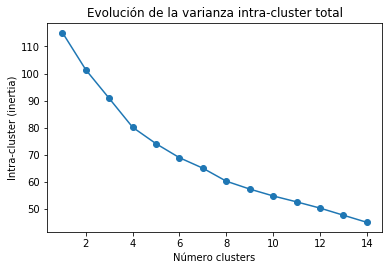

In [167]:
#Curva del Codo
Merida_grouped_clustering = Merida_grouped.drop('Neighborhood', 1)
X=Merida_grouped_clustering

# Método elbow para identificar el número óptimo de clusters

range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit(X)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

A partir de 8 clusters la reducción en la suma total de cuadrados internos parece estabilizarse, indicando que K = 8 es una buena opción.

In [168]:
# establecer el número de agrupaciones
kclusters = 8

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Merida_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:10] 

array([3, 4, 3, 3, 5, 3, 3, 0, 3, 3])

Generemos un nuevo dataframe que incluya la agrupación asi como los 10 sitios mas populares de cada barrio.

In [169]:
# añadir etiquetas
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Merida_merged = Merida
# juntar Merida_grouped con Merida 
Merida_merged = Merida_merged.join(neighborhoods_venues_sorted.set_index('Colonia'), on='Colonia')

CP                        Colonia    Latitud   Longitud  Cluster Labels  \
0  97000      jardines de san sebastian  20.989200 -89.756400             NaN   
1  97000            privada del maestro  20.982308 -89.626156             3.0   
2  97000                  merida centro  20.968927 -89.645942             3.0   
3  97000                      los cocos  20.948595 -89.630134             2.0   
4  97000  privada garcia gineres c - 29  20.989226 -89.638116             3.0   

         1st Most Common Venue 2nd Most Common Venue  \
0                          NaN                   NaN   
1  Grocery Store / Supermarket     Automotive Retail   
2                         Park               Brewery   
3                         Park              Pizzeria   
4                         Bank             Drugstore   

      3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0                       NaN                    NaN                   NaN   
1               Comedy Club                    Pub          Concert Hall   
2  Food and Beverage Retail        Taco Restaurant            Shoe Store   
3        Mexican Restaurant            Pet Service     Convenience Store   
4             Design Studio  Motorcycle Dealership              Pizzeria   

                6th Most Common Venue  7th Most Common Venue  \
0                                 NaN                    NaN   
1                       Legal Service        Taco Restaurant   
2                               Beach  Performing Arts Venue   
3                Yucatecan Restaurant       Department Store   
4  Business and Professional Services    American Restaurant   

  8th Most Common Venue     9th Most Common Venue 10th Most Common Venue  
0                   NaN                       NaN                    NaN  
1                   Bar        Chinese Restaurant            Wings Joint  
2               Daycare  Equipment Rental Service             Dive Store  
3         Design Studio              Dessert Shop                  Diner  
4        Car Dealership              Dessert Shop                  Diner

In [171]:
Merida_merged = Merida_merged[Merida_merged['Cluster Labels'].notna()]
Merida_merged.head() # revisar las ultimas columnas

CP                        Colonia    Latitud   Longitud  Cluster Labels  \
1  97000            privada del maestro  20.982308 -89.626156             3.0   
2  97000                  merida centro  20.968927 -89.645942             3.0   
3  97000                      los cocos  20.948595 -89.630134             2.0   
4  97000  privada garcia gineres c - 29  20.989226 -89.638116             3.0   
5  97003                      los reyes  20.978651 -89.575990             3.0   

         1st Most Common Venue 2nd Most Common Venue  \
1  Grocery Store / Supermarket     Automotive Retail   
2                         Park               Brewery   
3                         Park              Pizzeria   
4                         Bank             Drugstore   
5                     Pizzeria            Playground   

      3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
1               Comedy Club                    Pub          Concert Hall   
2  Food and Beverage Retail        Taco Restaurant            Shoe Store   
3        Mexican Restaurant            Pet Service     Convenience Store   
4             Design Studio  Motorcycle Dealership              Pizzeria   
5                Nail Salon     Seafood Restaurant      Website Designer   

                6th Most Common Venue  7th Most Common Venue  \
1                       Legal Service        Taco Restaurant   
2                               Beach  Performing Arts Venue   
3                Yucatecan Restaurant       Department Store   
4  Business and Professional Services    American Restaurant   
5                   Convenience Store    Miscellaneous Store   

  8th Most Common Venue     9th Most Common Venue 10th Most Common Venue  
1                   Bar        Chinese Restaurant            Wings Joint  
2               Daycare  Equipment Rental Service             Dive Store  
3         Design Studio              Dessert Shop                  Diner  
4        Car Dealership              Dessert Shop                  Diner  
5  Other Great Outdoors              Construction                  Diner

Finalmente visualicemos las agrupaciones resultantes

In [187]:
# crear mapa
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(Merida_merged['Latitud'], Merida_merged['Longitud'], Merida_merged['Colonia'], Merida_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examinamos Agrupaciones

Ahora examinamos cada agrupación y determinamos las categorias del sitio que distingue a cada agrupación

#### Agrupación 1

In [175]:
Merida_merged.loc[Merida_merged['Cluster Labels'] == 0, Merida_merged.columns[[1] + list(range(5, Merida_merged.shape[1]))]]

Colonia 1st Most Common Venue 2nd Most Common Venue  \
106         san miguel  Other Great Outdoors  Yucatecan Restaurant   
466       libertad iii  Other Great Outdoors  Yucatecan Restaurant   
467     renacimiento i  Other Great Outdoors  Yucatecan Restaurant   
469  industrial bridec  Other Great Outdoors  Yucatecan Restaurant   
470    renacimiento ii  Other Great Outdoors  Yucatecan Restaurant   
471   graciano ricalde  Other Great Outdoors  Yucatecan Restaurant   
472      villas merida  Other Great Outdoors  Yucatecan Restaurant   
473  residencial nicte  Other Great Outdoors  Yucatecan Restaurant   
474      alvaro torres  Other Great Outdoors  Yucatecan Restaurant   
475        libertad ii  Other Great Outdoors  Yucatecan Restaurant   
476         pino surez  Other Great Outdoors  Yucatecan Restaurant   
575           tamanche  Other Great Outdoors          Soccer Field   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
106               Daycare      Department Store         Design Studio   
466               Daycare      Department Store         Design Studio   
467               Daycare      Department Store         Design Studio   
469               Daycare      Department Store         Design Studio   
470               Daycare      Department Store         Design Studio   
471               Daycare      Department Store         Design Studio   
472               Daycare      Department Store         Design Studio   
473               Daycare      Department Store         Design Studio   
474               Daycare      Department Store         Design Studio   
475               Daycare      Department Store         Design Studio   
476               Daycare      Department Store         Design Studio   
575                  Park  Yucatecan Restaurant        Discount Store   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
106          Dessert Shop                 Diner   Dining and Drinking   
466          Dessert Shop                 Diner   Dining and Drinking   
467          Dessert Shop                 Diner   Dining and Drinking   
469          Dessert Shop                 Diner   Dining and Drinking   
470          Dessert Shop                 Diner   Dining and Drinking   
471          Dessert Shop                 Diner   Dining and Drinking   
472          Dessert Shop                 Diner   Dining and Drinking   
473          Dessert Shop                 Diner   Dining and Drinking   
474          Dessert Shop                 Diner   Dining and Drinking   
475          Dessert Shop                 Diner   Dining and Drinking   
476          Dessert Shop                 Diner   Dining and Drinking   
575      Department Store         Design Studio          Dessert Shop   

    9th Most Common Venue 10th Most Common Venue  
106        Discount Store               Dive Bar  
466        Discount Store               Dive Bar  
467        Discount Store               Dive Bar  
469        Discount Store               Dive Bar  
470        Discount Store               Dive Bar  
471        Discount Store               Dive Bar  
472        Discount Store               Dive Bar  
473        Discount Store               Dive Bar  
474        Discount Store               Dive Bar  
475        Discount Store               Dive Bar  
476        Discount Store               Dive Bar  
575                 Diner    Dining and Drinking

#### Agrupación 2

In [176]:
Merida_merged.loc[Merida_merged['Cluster Labels'] == 1, Merida_merged.columns[[1] + list(range(5, Merida_merged.shape[1]))]]

Colonia 1st Most Common Venue 2nd Most Common Venue  \
555         royal del parque           Sports Club    Chinese Restaurant   
557               las fincas           Sports Club    Chinese Restaurant   
559  san antonio residencial           Sports Club    Chinese Restaurant   
560                    xotik           Sports Club    Chinese Restaurant   
561           los tamarindos           Sports Club    Chinese Restaurant   
562            n?cleo sodzil           Sports Club    Chinese Restaurant   
563                palmequen           Sports Club    Chinese Restaurant   
564     residencial xcanat?n           Sports Club    Chinese Restaurant   
565           piedra antigua           Sports Club    Chinese Restaurant   
566             real montejo           Sports Club    Chinese Restaurant   
567    residencial del mayab           Sports Club    Chinese Restaurant   
568             las americas           Sports Club    Chinese Restaurant   
569    club de golf la ceiba           Sports Club    Chinese Restaurant   
570          las americas ii           Sports Club    Chinese Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
555      Department Store         Design Studio          Dessert Shop   
557      Department Store         Design Studio          Dessert Shop   
559      Department Store         Design Studio          Dessert Shop   
560      Department Store         Design Studio          Dessert Shop   
561      Department Store         Design Studio          Dessert Shop   
562      Department Store         Design Studio          Dessert Shop   
563      Department Store         Design Studio          Dessert Shop   
564      Department Store         Design Studio          Dessert Shop   
565      Department Store         Design Studio          Dessert Shop   
566      Department Store         Design Studio          Dessert Shop   
567      Department Store         Design Studio          Dessert Shop   
568      Department Store         Design Studio          Dessert Shop   
569      Department Store         Design Studio          Dessert Shop   
570      Department Store         Design Studio          Dessert Shop   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
555                 Diner   Dining and Drinking        Discount Store   
557                 Diner   Dining and Drinking        Discount Store   
559                 Diner   Dining and Drinking        Discount Store   
560                 Diner   Dining and Drinking        Discount Store   
561                 Diner   Dining and Drinking        Discount Store   
562                 Diner   Dining and Drinking        Discount Store   
563                 Diner   Dining and Drinking        Discount Store   
564                 Diner   Dining and Drinking        Discount Store   
565                 Diner   Dining and Drinking        Discount Store   
566                 Diner   Dining and Drinking        Discount Store   
567                 Diner   Dining and Drinking        Discount Store   
568                 Diner   Dining and Drinking        Discount Store   
569                 Diner   Dining and Drinking        Discount Store   
570                 Diner   Dining and Drinking        Discount Store   

    9th Most Common Venue 10th Most Common Venue  
555              Dive Bar             Dive Store  
557              Dive Bar             Dive Store  
559              Dive Bar             Dive Store  
560              Dive Bar             Dive Store  
561              Dive Bar             Dive Store  
562              Dive Bar             Dive Store  
563              Dive Bar             Dive Store  
564              Dive Bar             Dive Store  
565              Dive Bar             Dive Store  
566              Dive Bar             Dive Store  
567              Dive Bar             Dive Store  
568              Dive Bar             Dive Store  
569              Dive Bar

#### Agrupación 3

In [177]:
Merida_merged.loc[Merida_merged['Cluster Labels'] == 2, Merida_merged.columns[[1] + list(range(5, Merida_merged.shape[1]))]]

Colonia        1st Most Common Venue  \
3                           los cocos                         Park   
10                             itzaes                         Deli   
30                      sol campestre                         Park   
59                         san carlos               Hardware Store   
63                         montecarlo                         Park   
95           jardines de vista alegre                         Park   
202                          san jose                       Retail   
229                tulias de chuburna                         Park   
239                 las haciendas iii                         Park   
242  privada chuburna de hidalgo (ii)  Grocery Store / Supermarket   
253            cordeleros de chuburna                         Park   
262          vista alegre de chuburna                         Park   
267                   san pedro uxmal                         Park   
272                       bugambilias                 Dance Studio   
300                        el rosario    Health and Beauty Service   
363                     lindavista ii                         Park   
396            armando avila gurrutia               Hardware Store   
397                         bojorquez               Hardware Store   
398                 central de abasto               Hardware Store   
399           residencial casa blanca               Hardware Store   
400              villas de yacalpeten               Hardware Store   
401  brisas del poniente (yucalpeten)               Hardware Store   
402                        yucalpeten               Hardware Store   
403                     nora quintana               Hardware Store   
404            jardines de yucalpeten               Hardware Store   
405           yucalpeten secc florida               Hardware Store   
406                francisco i madero                         Park   
477                 salvador alvarado                         Deli   
479                            obrera               Hardware Store   
480                 circuito colonias               Hardware Store   
481                      nueva obrera               Hardware Store   
482                     villa moderna               Hardware Store   
483             villa de la obrera ii               Hardware Store   
484                  villas del mayab               Hardware Store   
485                       manzana 115               Hardware Store   
486                   quinta valencia               Hardware Store   
487               delio moreno canton               Hardware Store   
488          santa maria de guadalupe               Hardware Store   
489                   meliton salazar               Hardware Store   
490                   las palmeras ii               Hardware Store   
502                     san jose tzal                       Retail   
524                 san antonio xluch               Hardware Store   
525              nueva san jose tecoh               Hardware Store   
526              san antonio xluch ii               Hardware Store   
528                        san marcos           Automotive Service   
573                            noc ac                         Park   
576                             xcuny                         Park   
580                            cholul            Convenience Store   
581                    granjas cholul            Convenience Store   
596                           sitpach                   Night Club   
608                          tixcacal                         Park   
611                          la ceiba                 Organization   
656                          xmatkuil                       Retail   

         2nd Most Common Venue        3rd Most Common Venue  \
3                     Pizzeria           Mexican Restaurant   
10                        Park            Convenience Store   
30          Mexican Restaurant                   Restaurant 

#### Agrupación 4

In [179]:
Merida_merged.loc[Merida_merged['Cluster Labels'] == 3, Merida_merged.columns[[1] + list(range(5, Merida_merged.shape[1]))]]

Colonia  \
1                         privada del maestro   
2                               merida centro   
4               privada garcia gineres c - 29   
5                                   los reyes   
6                                     yucatan   
7                                alcal martin   
8                                    seoorial   
9                             carrillo ancona   
11                                 inalmbrica   
12                             dolores patron   
13                                el pedregal   
14                             garcia gineres   
15                                  la huerta   
16                              santa cecilia   
17                                    cupules   
18                                    lourdes   
19                                      waspa   
20                                  itzimna 2   
21                                    itzimna   
22                          rinconada itzmina   
23                              las arboledas   
24                             jesus carranza   
25                            ferrocarrileros   
26                                  xaman-tan   
27                                san antonio   
28                                 montebello   
29                       gran royal altabrisa   
31                                monte alban   
32                    privada monterreal plus   
33                           hacienda dzodzil   
34                                   cordemex   
35                           gonzalo guerrero   
36                     residencial san angelo   
37                              montes de ame   
38                          san antonio cucul   
39                            san ramon norte   
40                              plan de ayala   
41                             villas del sol   
42                         villas la hacienda   
43                           benito jurez nte   
44                           gonzalo guerrero   
45                                tecnolugico   
46                                  campestre   
47                                  del norte   
48                          centro sct yucatn   
49                       privada nuevo mexico   
50                                    montejo   
51                                 buenavista   
52                        privada mediterrneo   
53                 residencial colonia mexico   
54                        privada real mexico   
55                               mexico norte   
56                        emiliano zapata nte   
57                               vista alegre   
58                                   san remo   
60                       privada vista alegre   
62                                 diaz ordaz   
64                               privada maya   
65                                  altabrisa   
66                       cumbres de altabrisa   
67                                  missan ii   
68        residencial palmerales de altabrisa   
69                          santa rita cholul   
70                               torremolinos   
71                         vista alegre norte   
73       residencial camara de comercio norte   
74                   camara de comercio norte   
75                  los palmares de altabrisa   
76                                 monterreal   
77                                 montevideo   
78                                       maya   
79                       privada villa cholul   
80                       jose maria iturralde   
81                               paraiso maya   
82                         jardines de merida   
83                 felipe carrillo puerto nte   
84                             mexico oriente   
85                                santa maria   
86                           san pedro cholul   
87                                  los pinos   
93                                    el arco   
94                ja

#### Agrupación 5

In [180]:
Merida_merged.loc[Merida_merged['Cluster Labels'] == 4, Merida_merged.columns[[1] + list(range(5, Merida_merged.shape[1]))]]

Colonia               1st Most Common Venue  \
329                          tanlum  Business and Professional Services   
330        joaquin ceballos mimenza  Business and Professional Services   
331            pedregales de tanlum  Business and Professional Services   
332                aguilas chuburna  Business and Professional Services   
333             colonial buenavista  Business and Professional Services   
334               colonial chuburna  Business and Professional Services   
335       residencial pensiones iii  Business and Professional Services   
336        residencial pensiones vi  Business and Professional Services   
337    residencial pensiones i y ii  Business and Professional Services   
338         residencial pensiones v  Business and Professional Services   
339  residencial pensiones iii (ii)  Business and Professional Services   
340                       fovissste  Business and Professional Services   
341           francisco el porvenir  Business and Professional Services   
342        residencial pensiones iv  Business and Professional Services   
343                 pensiones norte  Business and Professional Services   
344   residencial pensiones iii (1)  Business and Professional Services   
533             san marcos nocoh ii  Business and Professional Services   
534         emiliano zapata sur iii  Business and Professional Services   
535          emiliano zapata sur ii  Business and Professional Services   
536                  villas quetzal  Business and Professional Services   
537             emiliano zapata sur  Business and Professional Services   
538                   metropolitana  Business and Professional Services   
540           san antonio xluch iii  Business and Professional Services   
541              privada zuzil - ha  Business and Professional Services   
542                         zacilha  Business and Professional Services   
543              brisas de san jose  Business and Professional Services   
544                   zazil - ha ii  Business and Professional Services   
545              san jose tecoh sur  Business and Professional Services   
546                  san jose tecoh  Business and Professional Services   
547               san antonio tecoh  Business and Professional Services   
663                       dzoyaxche                              Garden   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
329                Garden     Convenience Store      Department Store   
330                Garden     Convenience Store      Department Store   
331                Garden     Convenience Store      Department Store   
332                Garden     Convenience Store      Department Store   
333                Garden     Convenience Store      Department Store   
334                Garden     Convenience Store      Department Store   
335                Garden     Convenience Store      Department Store   
336                Garden     Convenience Store      Department Store   
337                Garden     Convenience Store      Department Store   
338                Garden     Convenience Store      Department Store   
339                Garden     Convenience Store      Department Store   
340                Garden     Convenience Store      Department Store   
341                Garden     Convenience Store      Department Store   
342                Garden     Convenience Store      Department Store   
343                Garden     Convenience Store      Department Store   
344                Garden     Convenience Store      Department Store   
533                Garden                  Deli      Department Store   
534                Garden                  Deli      Department Store   
535                Garden                  Deli      Department Store   
536                Garden                  Deli      Department Store   
537                Garden                  Deli      Department Store   
538                Ga

#### Agrupación 6

In [181]:
Merida_merged.loc[Merida_merged['Cluster Labels'] == 5, Merida_merged.columns[[1] + list(range(5, Merida_merged.shape[1]))]]

Colonia              1st Most Common Venue  \
223                                 merida                         Restaurant   
226                 chuburna de hidalgo iv                         Restaurant   
227                        rincun colonial                         Restaurant   
228        ampliaciun francisco de montejo                         Restaurant   
233              camara de la construcciun                         Restaurant   
240                         nuevo san jose                         Restaurant   
243                nueva san jose chuburna                         Restaurant   
245              san francisco chuburna ii                         Restaurant   
246                              almendros                         Restaurant   
249     lotificacion chuburna de hidalgo i                         Restaurant   
252                  chuburna de hidalgo v                         Restaurant   
254    lotificacion chuburna de hidalgo ii                         Restaurant   
255                     privada las palmas                         Restaurant   
256                  privada palma corozal                         Restaurant   
257            industrias no contaminantes                         Restaurant   
260                chuburna de hidalgo iii                         Restaurant   
263                      villas las palmas                         Restaurant   
266               privada villa palma real                         Restaurant   
529                             santa cruz                         Restaurant   
530                      el roble agricola                         Restaurant   
531  merida (lic. manuel crescencio rejon)                         Restaurant   
606                                   oncn  Chemicals and Gasses Manufacturer   
660                   santa cruz palomeque                         Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
223              Wine Bar                  Café    Mexican Restaurant   
226              Wine Bar                  Café    Mexican Restaurant   
227              Wine Bar                  Café    Mexican Restaurant   
228              Wine Bar                  Café    Mexican Restaurant   
233              Wine Bar                  Café    Mexican Restaurant   
240              Wine Bar                  Café    Mexican Restaurant   
243              Wine Bar                  Café    Mexican Restaurant   
245              Wine Bar                  Café    Mexican Restaurant   
246              Wine Bar                  Café    Mexican Restaurant   
249              Wine Bar                  Café    Mexican Restaurant   
252              Wine Bar                  Café    Mexican Restaurant   
254              Wine Bar                  Café    Mexican Restaurant   
255              Wine Bar                  Café    Mexican Restaurant   
256              Wine Bar                  Café    Mexican Restaurant   
257              Wine Bar                  Café    Mexican Restaurant   
260              Wine Bar                  Café    Mexican Restaurant   
263              Wine Bar                  Café    Mexican Restaurant   
266              Wine Bar                  Café    Mexican Restaurant   
529  Yucatecan Restaurant               Daycare      Department Store   
530  Yucatecan Restaurant               Daycare      Department Store   
531  Yucatecan Restaurant               Daycare      Department Store   
606         Event Service            Restaurant        Discount Store   
660  Yucatecan Restaurant               Daycare      Department Store   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
223     German Restaurant                   Bar  Yucatecan Restaurant   
226     German Restaurant                   Bar  Yucatecan Restaurant   
227     German Restaurant      Asian Restaurant   Dining and Drinking   
228     German Restaurant                   B

#### Agrupación 7

In [182]:
Merida_merged.loc[Merida_merged['Cluster Labels'] == 6, Merida_merged.columns[[1] + list(range(5, Merida_merged.shape[1]))]]

Colonia 1st Most Common Venue  \
302                    san francisco i         Big Box Store   
303                   privada san jose         Big Box Store   
304             san francisco chuburna         Big Box Store   
306                         san jose i         Big Box Store   
307                 villas chuburna iv         Big Box Store   
308               residencial la noria         Big Box Store   
309               residencial turquesa         Big Box Store   
310                   privada cipreses         Big Box Store   
311           merida (elefante grande)         Big Box Store   
312  lotificacion san vicente chuburna         Big Box Store   
313                        san jose ii         Big Box Store   
314                privada la hacienda         Big Box Store   
315               san vicente chuburna         Big Box Store   

           2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
302  Grocery Store / Supermarket            Dive Store         Design Studio   
303  Grocery Store / Supermarket            Dive Store         Design Studio   
304  Grocery Store / Supermarket            Dive Store         Design Studio   
306  Grocery Store / Supermarket            Dive Store         Design Studio   
307  Grocery Store / Supermarket            Dive Store         Design Studio   
308  Grocery Store / Supermarket            Dive Store         Design Studio   
309  Grocery Store / Supermarket            Dive Store         Design Studio   
310  Grocery Store / Supermarket            Dive Store         Design Studio   
311  Grocery Store / Supermarket            Dive Store         Design Studio   
312  Grocery Store / Supermarket            Dive Store         Design Studio   
313  Grocery Store / Supermarket            Dive Store         Design Studio   
314  Grocery Store / Supermarket            Dive Store         Design Studio   
315  Grocery Store / Supermarket            Dive Store         Design Studio   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
302          Dessert Shop                 Diner   Dining and Drinking   
303          Dessert Shop                 Diner   Dining and Drinking   
304          Dessert Shop                 Diner   Dining and Drinking   
306          Dessert Shop                 Diner   Dining and Drinking   
307          Dessert Shop                 Diner   Dining and Drinking   
308          Dessert Shop                 Diner   Dining and Drinking   
309          Dessert Shop                 Diner   Dining and Drinking   
310          Dessert Shop                 Diner   Dining and Drinking   
311          Dessert Shop                 Diner   Dining and Drinking   
312          Dessert Shop                 Diner   Dining and Drinking   
313          Dessert Shop                 Diner   Dining and Drinking   
314          Dessert Shop                 Diner   Dining and Drinking   
315          Dessert Shop                 Diner   Dining and Drinking   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
302        Discount Store              Dive Bar               Dog Park  
303        Discount Store              Dive Bar               Dog Park  
304        Discount Store              Dive Bar               Dog Park  
306        Discount Store              Dive Bar               Dog Park  
307        Discount Store              Dive Bar               Dog Park  
308        Discount Store              Dive Bar               Dog Park  
309        Discount Store              Dive Bar               Dog Park  
310        Discount Store              Dive Bar               Dog Park  
311        Discount Store              Dive Bar               Dog Park  
312        Discount Store              Dive Bar               Dog Park  
313        Discount Store              Dive Bar               Dog Park  
314        Discount Store              Dive Bar               Dog Park  
315        Discount Store              Di

#### Agrupación 8

In [183]:
Merida_merged.loc[Merida_merged['Cluster Labels'] == 7, Merida_merged.columns[[1] + list(range(5, Merida_merged.shape[1]))]]

Colonia 1st Most Common Venue 2nd Most Common Venue  \
491         dolores otero         Swimming Pool  Yucatecan Restaurant   
492      mercedes barrera         Swimming Pool  Yucatecan Restaurant   
493       castilla camara         Swimming Pool  Yucatecan Restaurant   
494  bosques del pedregal         Swimming Pool  Yucatecan Restaurant   
495            santa rosa         Swimming Pool  Yucatecan Restaurant   
496     quinta santa rosa         Swimming Pool  Yucatecan Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
491              Dive Bar      Department Store         Design Studio   
492              Dive Bar      Department Store         Design Studio   
493              Dive Bar      Department Store         Design Studio   
494              Dive Bar      Department Store         Design Studio   
495              Dive Bar      Department Store         Design Studio   
496              Dive Bar      Department Store         Design Studio   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
491          Dessert Shop                 Diner   Dining and Drinking   
492          Dessert Shop                 Diner   Dining and Drinking   
493          Dessert Shop                 Diner   Dining and Drinking   
494          Dessert Shop                 Diner   Dining and Drinking   
495          Dessert Shop                 Diner   Dining and Drinking   
496          Dessert Shop                 Diner   Dining and Drinking   

    9th Most Common Venue 10th Most Common Venue  
491        Discount Store             Dive Store  
492        Discount Store             Dive Store  
493        Discount Store             Dive Store  
494        Discount Store             Dive Store  
495        Discount Store             Dive Store  
496        Discount Store             Dive Store

## Referencias

- https://inmobiliare.com/la-ciudad-de-merida-y-sus-centros-comerciales-en-2021/
- https://www.yucatan.gob.mx/saladeprensa/ver_nota.php?id=4156
-https://datamexico.org/es/profile/geo/merida#:~:text=Acerca%20de%20M%C3%A9rida&text=En%202020%2C%20la%20poblaci%C3%B3n%20en,85%25%20respecto%20al%20a%C3%B1o%20anterior.
- https://www.linkedin.com/pulse/analysing-clustering-neighborhoods-m%C3%A9rida-yucat%C3%A1n-castro-trejo
- https://stackoverflow-com.translate.goog/questions/11816844/object-of-type-nonetype-has-no-len-error?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es-419&_x_tr_pto=sc
- https://www.cienciadedatos.net/documentos/py20-clustering-con-python.html